# Projeto Integrado Final - Deep Learning

Desenvolvimento de modelo classificação utilizando Redes Neurais Convolucionais (CNN) ou Redes Neurais Recorrentes (RNN), com base na tendencia de mercado dos ultimos 15 dias, considerando o "close" da ação em base de dados suavizada. 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, LSTM, Dropout, MaxPooling1D, Flatten
from tensorflow.keras.utils import to_categorical, plot_model
from keras.callbacks import ModelCheckpoint
from collections import defaultdict

In [4]:
df_train = pd.read_csv('../src/data/PETR4.SA/treino.csv')
df_test = pd.read_csv('../src/data/PETR4.SA/teste.csv')

## Exploratory Data Analysis

In [5]:
df_train.head(2)

,Unnamed: 0,Date,Close,Smoothed_Close,Label,Past_1_Days_Close,Past_2_Days_Close,Past_3_Days_Close,Past_4_Days_Close,Past_5_Days_Close,Past_6_Days_Close,Past_7_Days_Close,Past_8_Days_Close,Past_9_Days_Close,Past_10_Days_Close,Past_11_Days_Close,Past_12_Days_Close,Past_13_Days_Close,Past_14_Days_Close,Past_15_Days_Close
0,1,2000-01-24,1.274788,1.347845,-1,1.283923,1.311824,1.314787,1.324169,1.317996,1.333305,1.314787,1.353798,1.351823,1.385896,1.357995,1.351823,1.356514,1.370341,1.450586
1,2,2000-01-25,1.274788,1.340540,-1,1.274788,1.283923,1.311824,1.314787,1.324169,1.317996,1.333305,1.314787,1.353798,1.351823,1.385896,1.357995,1.351823,1.356514,1.370341


In [6]:
df_test.head(2)

,Unnamed: 0,Date,Close,Smoothed_Close,Label,Past_1_Days_Close,Past_2_Days_Close,Past_3_Days_Close,Past_4_Days_Close,Past_5_Days_Close,Past_6_Days_Close,Past_7_Days_Close,Past_8_Days_Close,Past_9_Days_Close,Past_10_Days_Close,Past_11_Days_Close,Past_12_Days_Close,Past_13_Days_Close,Past_14_Days_Close,Past_15_Days_Close
0,4809,2019-02-26,9.467936,9.376527,1,9.510681,9.663848,9.760024,9.631790,9.752899,9.532050,9.560549,9.599731,9.279146,9.161598,8.848140,8.951439,8.937191,9.079673,9.289832
1,4810,2019-02-27,9.646040,9.403478,1,9.467936,9.510681,9.663848,9.760024,9.631790,9.752899,9.532050,9.560549,9.599731,9.279146,9.161598,8.848140,8.951439,8.937191,9.079673


In [7]:
nome_arquivo = 'PETR4'
# EDA
print(f"EDA para {nome_arquivo}:")
print(f"Descrição dos dados:\n{df_train.describe()}\n")
print(f"Contagem de valores NaN por coluna:\n{df_train.isna().sum()}\n")
print(f"Contagem dos rótulos:\n{df_train['Label'].value_counts()}\n")


EDA para PETR4:
Descrição dos dados:
        Unnamed: 0        Close  Smoothed_Close        Label  \
count  4808.000000  4808.000000     4808.000000  4808.000000   
mean   2404.500000     5.126396        5.111402    -0.103993   
std    1388.094377     2.810534        2.790427     0.994681   
min       1.000000     1.080224        1.200894    -1.000000   
25%    1202.750000     2.523248        2.533339    -1.000000   
50%    2404.500000     5.331852        5.349307    -1.000000   
75%    3606.250000     6.990364        6.965855     1.000000   
max    4808.000000    14.551721       13.432679     1.000000   

       Past_1_Days_Close  Past_2_Days_Close  Past_3_Days_Close  \
count        4808.000000        4808.000000        4808.000000   
mean            5.124685           5.122948           5.121191   
std             2.810369           2.810144           2.809884   
min             1.080224           1.080224           1.080224   
25%             2.519004           2.518208           2.

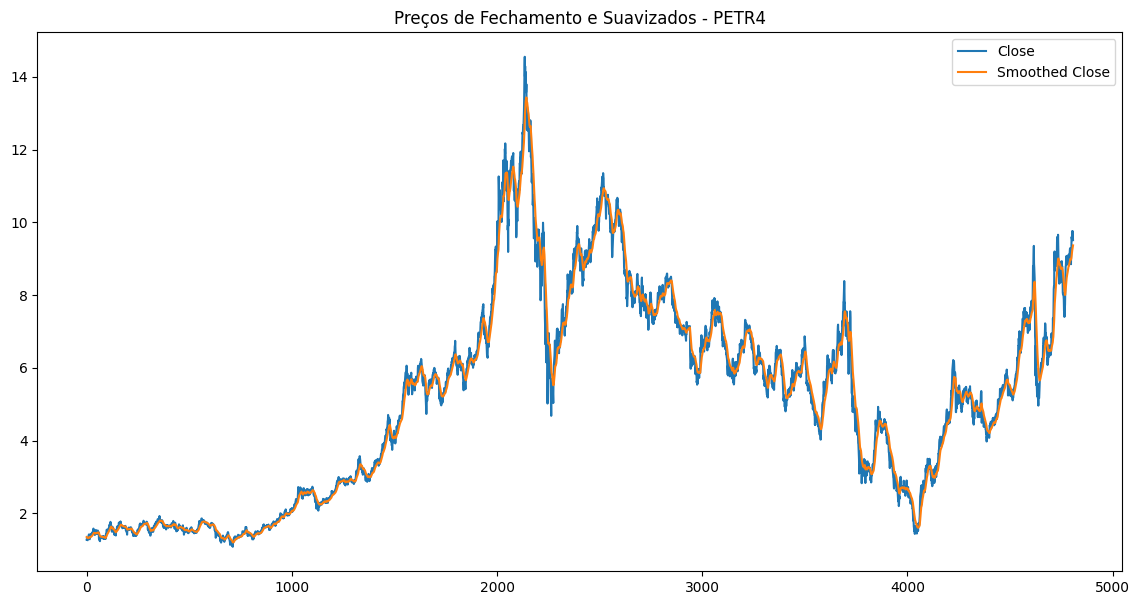

In [8]:
# COMPARAÇÃO ENTRE PREÇOS DE FECHAMENTO E PREÇOS DE FECHAMENTO SUAVIZADOS
plt.figure(figsize=(14, 7))
plt.plot(df_train['Close'], label='Close')
plt.plot(df_train['Smoothed_Close'], label='Smoothed Close')
plt.title(f'Preços de Fechamento e Suavizados - {nome_arquivo}')
plt.legend()
plt.show()

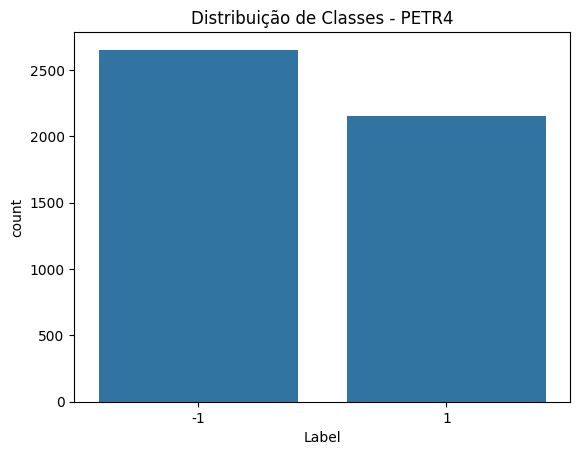

In [9]:
# DISTRIBUIÇÃO DOS RÓTULOS
sns.countplot(x='Label', data=df_train)
plt.title(f'Distribuição de Classes - {nome_arquivo}')
plt.show()

## Treinamento de modelo de Redes Neurais Recorrentes (RNN)

In [10]:
## NORMALIZAÇÃO DOS DADOS

# Normalizador para as features
scaler = StandardScaler()

# Função para converter rótulos em formato categórico
def converter_para_categorico(y):
    if y.min() == -1:  # Se os rótulos forem -1 e 1
        y = (y + 1) // 2  # Converter rótulos para 0 e 1
    return to_categorical(y)

X_train = df_train.drop(['Date', 'Close', 'Smoothed_Close', 'Label'], axis=1)
y_train = df_train['Label']

X_test = df_test.drop(['Date', 'Close', 'Smoothed_Close', 'Label'], axis=1)
y_test = df_test['Label']

# Normalizar as features
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# reshape da entrada para ser [amostras, time steps, caracteristicas]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Converter os rótulos para formato categórico
y_train_cat = converter_para_categorico(y_train)
y_test_cat = converter_para_categorico(y_test)

In [19]:
# Cria e treina a rede LSTM
historicos = {}

model_rnn = Sequential([     
        LSTM(150, return_sequences=True, input_shape=(X_train.shape[1], 1)),
        ##Dropout(0.1),
        LSTM(50),
        Dense(y_train_cat.shape[1], activation='sigmoid')
    ])

model_rnn.compile(loss='binary_crossentropy', metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='../models/melhor_rnn_PETR4.keras', verbose=1,  save_best_only=True, monitor='val_accuracy')

historico_rnn = model_rnn.fit(X_train, y_train_cat, epochs=70, batch_size=8, validation_split=0.1, verbose=1, callbacks=[checkpointer],shuffle=True)


Epoch 1/70


/Users/cintia.duarte/Documents/develop/NEURAL-NETWORKS-REGRESSION/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


535/541 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5408 - loss: 0.6903
Epoch 1: val_accuracy improved from -inf to 0.47193, saving model to ../models/melhor_rnn_PETR4.keras
541/541 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.5411 - loss: 0.6902 - val_accuracy: 0.4719 - val_loss: 0.6759
Epoch 2/70
538/541 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5908 - loss: 0.6601
Epoch 2: val_accuracy improved from 0.47193 to 0.61331, saving model to ../models/melhor_rnn_PETR4.keras
541/541 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5909 - loss: 0.6600 - val_accuracy: 0.6133 - val_loss: 0.6164
Epoch 3/70
535/541 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6461 - loss: 0.6120
Epoch 3: val_accuracy improved from 0.61331 to 0.74428, saving model to ../models/melhor_rnn_PETR4.keras
541/541 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.6463 - loss: 0.6118 - val_accuracy: 0.7443 - val_loss: 0.4847
Epoch 4/70
539/541 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6935 - loss: 0.5738
Epoc

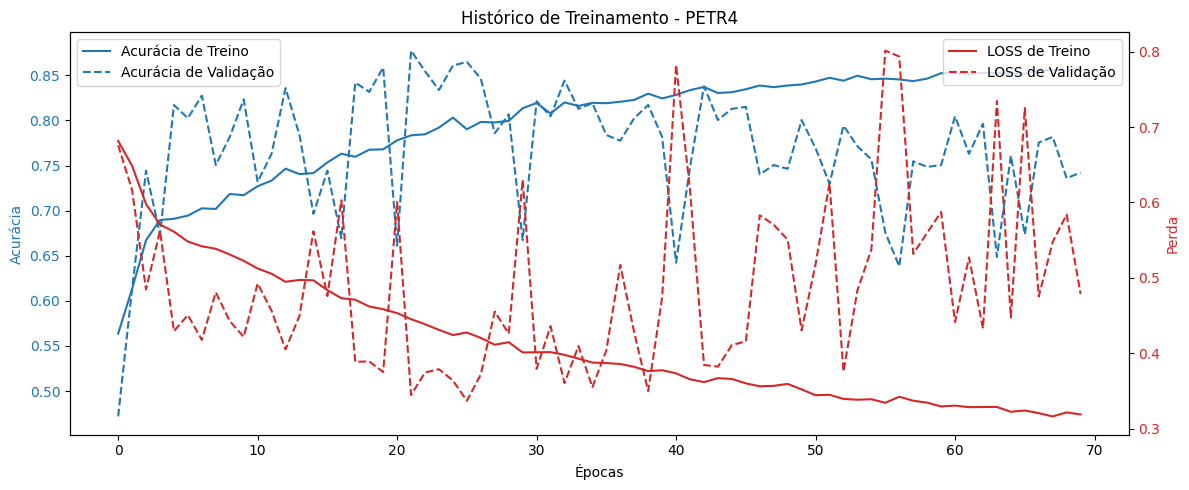

In [26]:
def plotar_historico(historico, titulo):
    fig, ax1 = plt.subplots(figsize=(12, 5))

    color = 'tab:blue'
    ax1.set_xlabel('Épocas')
    ax1.set_ylabel('Acurácia', color=color)
    ax1.plot(historico.history['accuracy'], label='Acurácia de Treino', color=color)
    if 'val_accuracy' in historico.history:
        ax1.plot(historico.history['val_accuracy'], label='Acurácia de Validação', color=color, linestyle='--')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc='upper left')
    
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:red'
    ax2.set_ylabel('Perda', color=color)  # we already handled the x-label with ax1
    ax2.plot(historico.history['loss'], label='LOSS de Treino', color=color)
    if 'val_loss' in historico.history:
        ax2.plot(historico.history['val_loss'], label='LOSS de Validação', color=color, linestyle='--')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(loc='upper right')

    plt.title(titulo)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()



plotar_historico(historico_rnn, f"Histórico de Treinamento - {nome_arquivo}")

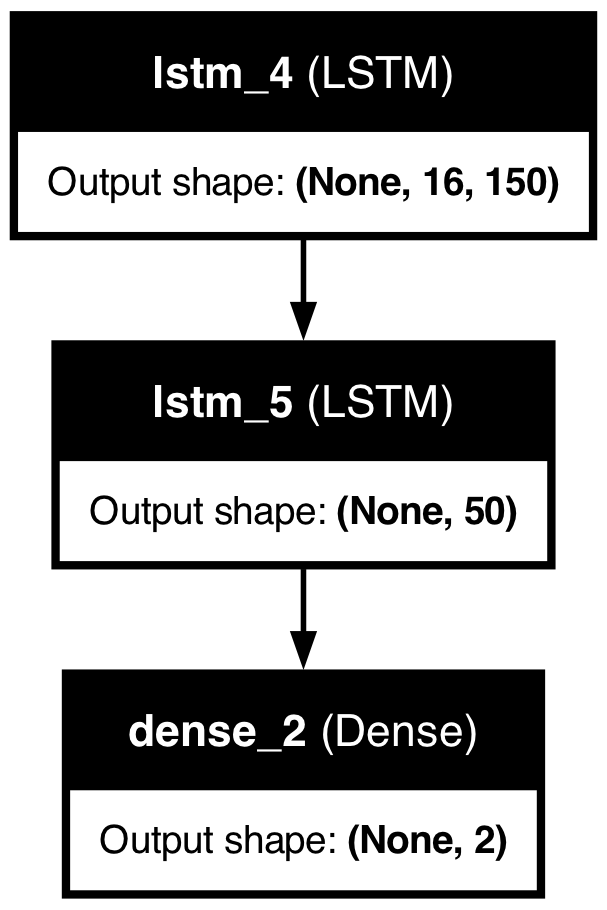

In [27]:
plot_model(model_rnn,show_shapes=True, show_layer_names=True)

PETR4 -> Acurácia: 57.27%
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Relatório de Classificação para PETR4:
               precision    recall  f1-score   support

           0       0.54      0.74      0.63       581
           1       0.63      0.42      0.50       622

    accuracy                           0.57      1203
   macro avg       0.59      0.58      0.56      1203
weighted avg       0.59      0.57      0.56      1203




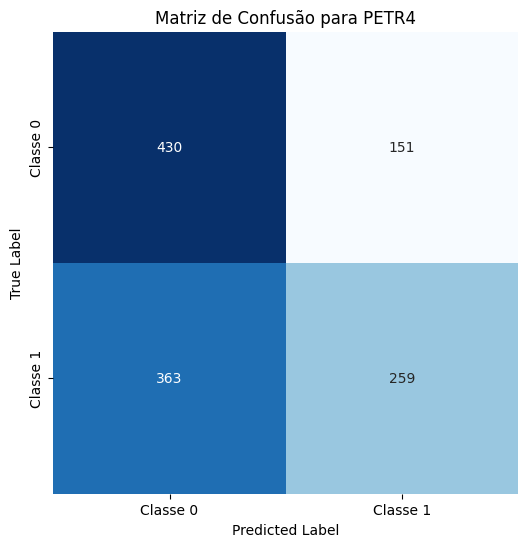

In [28]:
# Função para plotar a matriz de confusão
def plotar_matriz_confusao(cm, classes, title):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)

# Avaliar o modelo
scores = model_rnn.evaluate(X_test, y_test_cat, verbose=0)
print(f"{nome_arquivo} -> Acurácia: {scores[1]*100:.2f}%")

# Predições
y_pred = model_rnn.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_teste_classes = np.argmax(y_test_cat, axis=1)

# Gerar e plotar a matriz de confusão
cm = confusion_matrix(y_teste_classes, y_pred_classes)
plotar_matriz_confusao(cm, classes=['Classe 0', 'Classe 1'], title=f'Matriz de Confusão para {nome_arquivo}')

# Gerar relatório de classificação
print(f"Relatório de Classificação para {nome_arquivo}:\n {classification_report(y_teste_classes, y_pred_classes)}\n")